## Create videos

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
%matplotlib notebook
import essential_functions as ef
from essential_functions import *
import os

_MODEL_DIR = "kaggle_models/"
_DATA_DIR = "data/"

_DATA = "data/final_translated_data_1_3.csv"
_MODEL = "trained_models/medium_foil_model4.h5"#"kaggle_models/model_3_0-0125.h5"

data = load_data(filename=_DATA)
t_orig,x_orig,y_orig,u_orig,v_orig,p_orig,eta_orig = create_tensors(data)
scaler = scale_learn(t_orig,x_orig,y_orig,u_orig,v_orig,p_orig,eta_orig)
t,x,y,u,v,p,eta = scale(scaler,t_orig,x_orig,y_orig,u_orig,v_orig,p_orig,eta_orig)
print("[INFO] Number of data points: " +str(t.shape[0]))

/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3

[INFO] Time taken = 5.931596279144287 seconds.
[INFO] Number of data points: 3886682


In [2]:
def custom_loss_wrapper(Re):
#     input_tensor = concatenate([t, x, y], 1)
    def gradient_calc(Re):
        
        uvp = model.output
        u = uvp[:,0:1]
        v = uvp[:,1:2]
        p = uvp[:,2:3]
        eta = uvp[:,3:4]
#         print(u)
        
        u_t,u_x,u_y = K.gradients(u,model.input)
        v_t,v_x,v_y = K.gradients(v,model.input)
        p_t,p_x,p_y = K.gradients(p,model.input)
        eta_t,eta_x,eta_y = K.gradients(eta,model.input)
        
        u_xx = K.gradients(u_x,model.input[1])[0]
        u_yy = K.gradients(u_y,model.input[2])[0]
        v_xx = K.gradients(v_x,model.input[1])[0]
        v_yy = K.gradients(v_y,model.input[2])[0]
        eta_tt = K.gradients(eta_t,model.input[0])[0]
        
#         print((u_xx)+(u_yy))
        
        eq1 = u_t + (u*u_x + v*u_y) + p_x - (1.0/Re)*(u_xx + u_yy)
        eq2 = v_t + (u*v_x + v*v_y) + p_y - (1.0/Re)*(v_xx + v_yy) + eta_tt
        eq3 = u_x + v_y
        
        loss = K.mean(tf.square(eq1)) + K.mean(tf.square(eq2)) + K.mean(tf.square(eq3))
        
#         print((u_xx))
        return loss

    def custom_loss(y_true, y_pred):
        navier_loss = gradient_calc(Re=Re)
#         navier_loss = net_VIV(input_tensor,y_pred,Re=1000)
        return tf.reduce_mean(tf.square(y_true - y_pred)) + navier_loss
    return custom_loss


In [3]:
model = load_model(_MODEL,compile=False)
model.compile(loss=custom_loss_wrapper(Re=1000), optimizer='adam', metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           64          input_1[0][0]                    
____________________________________________________________________________________________

In [4]:
plt.ioff()
def plot_figs(t_test,x_test,y_test,u_test,v_test,p_test,u_pred,v_pred,p_pred):
    
    fig, ax = newfig(2.0, 1.0)
    ax.axis('off')
    fig.suptitle("Time: "+str(t_test[0][0]))

    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.5, hspace=0.5)
        
    ########      Exact u(t,x,y)     ###########     
    ax = plt.subplot(gs[0:1, 0])
    h = plot_solution(x_test,y_test,u_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle21)
    plot_airfoil(ax)

    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $u(t,x,y)$', fontsize = 10)
    
    ########     Learned u(t,x,y)     ###########
    ax = plt.subplot(gs[0:1, 1])
    h = plot_solution(x_test,y_test,u_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle22)
    plot_airfoil(ax)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $u(t,x,y)$', fontsize = 10)
    
    ########     Difference u(t,x,y)     ###########
    ax = plt.subplot(gs[0:1, 2])
    h = plot_solution(x_test,y_test,u_pred-u_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle22)
    plot_airfoil(ax)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Error $u(t,x,y)$', fontsize = 10)
    
    ########      Exact v(t,x,y)     ###########     
    ax = plt.subplot(gs[1:2, 0])
    h = plot_solution(x_test,y_test,v_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle31)
    ax.axis('equal')
    plot_airfoil(ax)
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $v(t,x,y)$', fontsize = 10)
    
    ########     Learned v(t,x,y)     ###########
    ax = plt.subplot(gs[1:2, 1])
    h = plot_solution(x_test,y_test,v_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle32)
    ax.axis('equal')
    plot_airfoil(ax)
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $v(t,x,y)$', fontsize = 10)
    
    ########     Difference v(t,x,y)     ###########
    ax = plt.subplot(gs[1:2, 2])
    h = plot_solution(x_test,y_test,v_pred-v_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle22)
    plot_airfoil(ax)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Error $v(t,x,y)$', fontsize = 10)
    
    ########      Exact p(t,x,y)     ###########     
    ax = plt.subplot(gs[2:3, 0])
    h = plot_solution(x_test,y_test,p_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle41)
    ax.axis('equal')
    plot_airfoil(ax)
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $p(t,x,y)$', fontsize = 10)
    
    ########     Learned p(t,x,y)     ###########
    ax = plt.subplot(gs[2:3, 1])
    h = plot_solution(x_test,y_test,p_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle42)
    ax.axis('equal')
    plot_airfoil(ax)
        
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $p(t,x,y)$', fontsize = 10)
    
    ########     Difference p(t,x,y)     ###########
    ax = plt.subplot(gs[2:3, 2])
    h = plot_solution(x_test,y_test,p_pred-p_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle22)
    plot_airfoil(ax)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Error $p(t,x,y)$', fontsize = 10)    
    
    plt.close(fig)
    return fig

In [5]:
def get_data(data,timeVal):
    data_sub = data[data['t']==timeVal]
    return np.array(data_sub['u']).reshape((len(data_sub['u']),1)),np.array(data_sub['v']).reshape((len(data_sub['u']),1)),np.array(data_sub['p']).reshape((len(data_sub['u']),1)),np.array(data_sub['eta']).reshape((len(data_sub['u']),1)),np.array(data_sub['x']).reshape((len(data_sub['u']),1)),np.array(data_sub['y']).reshape((len(data_sub['u']),1))

In [6]:
timeVal = 2.1
u_pred,v_pred,p_pred,eta_pred=time_snap(timeVal,scaler,data,model,plot=False,print_error=False)
u_test,v_test,p_test,eta_test,x_test,y_test = get_data(data,timeVal)
t_test = np.full((u_test.shape[0], 1), 7)
u_pred,u_test

(array([[0.95014701],
        [0.11418114],
        [0.80614418],
        ...,
        [0.84790846],
        [0.8285841 ],
        [0.90547301]]),
 array([[ 0.94256335],
        [-0.28816486],
        [ 0.69548763],
        ...,
        [ 0.88293944],
        [ 0.87669537],
        [ 0.9160296 ]]))

In [7]:
f=plot_figs(t_test,x_test,y_test,u_test,v_test,p_test,u_pred,v_pred,p_pred)

In [20]:
def get_time_plot(timeVal,data=data,scaler=scaler,model=model):
    u_pred,v_pred,p_pred,eta_pred=time_snap(timeVal,scaler,data,model,plot=False,print_error=False)
    u_test,v_test,p_test,eta_test,x_test,y_test = get_data(data,timeVal)
    t_test = np.full((u_test.shape[0], 1), 7)
    fig = plot_figs(t_test,x_test,y_test,u_test,v_test,p_test,u_pred,v_pred,p_pred)
    return fig,rmse(u_pred,u_test),rmse(v_pred,v_test),rmse(p_pred,p_test)

In [9]:
get_time_plot(3)

<IPython.core.display.Javascript object>

In [10]:
# matplotlib.use("Agg")
# import matplotlib.pyplot as plt
# import matplotlib.animation as manimation

# FFMpegWriter = manimation.writers['ffmpeg']
# metadata = dict(title='DeepVIV', artist='Ritvik Pandey', comment='Movie support!')
# writer = FFMpegWriter(fps=60, metadata=metadata)

# with writer.saving(fig, "writer_test.mp4", 100):
#     for 
#     writer.grab_frame()

In [11]:
times = np.arange(1,3.01,0.01)
times

array([1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99, 2.  , 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09,
       2.1 , 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2 ,
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

img = [] # some array of images
frames = [] # for storing the generated images
r_us=[]
r_vs=[]
r_ps=[]
times=[]
fig = plt.figure()
for i,timeVal in enumerate(np.arange(1,3.01,0.01)):
    print("[INFO] Time: "+str(timeVal))
    f,r_u,r_v,r_p=get_time_plot(round(timeVal,2))
    
    times.append(round(timeVal,2))
    r_us.append(r_u)
    r_vs.append(r_v)
    r_ps.append(r_p)
    
    f.savefig("Figures/animation_frames/"+str(i)+".png")
    frames.append(f)


[INFO] Time: 1.0
[INFO] Time: 1.01
[INFO] Time: 1.02
[INFO] Time: 1.03
[INFO] Time: 1.04
[INFO] Time: 1.05
[INFO] Time: 1.06
[INFO] Time: 1.07
[INFO] Time: 1.08
[INFO] Time: 1.09
[INFO] Time: 1.1
[INFO] Time: 1.11
[INFO] Time: 1.12
[INFO] Time: 1.1300000000000001
[INFO] Time: 1.1400000000000001
[INFO] Time: 1.1500000000000001
[INFO] Time: 1.1600000000000001
[INFO] Time: 1.1700000000000002
[INFO] Time: 1.1800000000000002
[INFO] Time: 1.1900000000000002
[INFO] Time: 1.2000000000000002
[INFO] Time: 1.2100000000000002
[INFO] Time: 1.2200000000000002
[INFO] Time: 1.2300000000000002
[INFO] Time: 1.2400000000000002
[INFO] Time: 1.2500000000000002
[INFO] Time: 1.2600000000000002
[INFO] Time: 1.2700000000000002
[INFO] Time: 1.2800000000000002
[INFO] Time: 1.2900000000000003
[INFO] Time: 1.3000000000000003
[INFO] Time: 1.3100000000000003
[INFO] Time: 1.3200000000000003
[INFO] Time: 1.3300000000000003
[INFO] Time: 1.3400000000000003
[INFO] Time: 1.3500000000000003
[INFO] Time: 1.3600000000000003


<IPython.core.display.Javascript object>


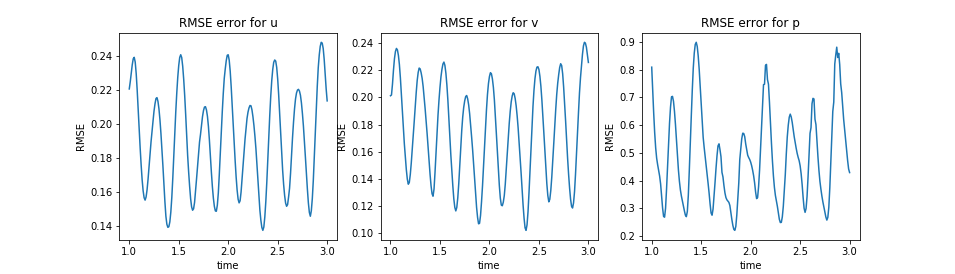

In [24]:
fig = plt.Figure(figsize=(1500,200))

plt.subplot(1,3,1)
plt.plot(times,r_us)
plt.title("RMSE error for u")
plt.xlabel("time")
plt.ylabel("RMSE")

plt.subplot(1,3,2)
plt.plot(times,r_vs)
plt.title("RMSE error for v")
plt.xlabel("time")
plt.ylabel("RMSE")

plt.subplot(1,3,3)
plt.plot(times,r_ps)
plt.title("RMSE error for p")
plt.xlabel("time")
plt.ylabel("RMSE")

plt.show()